In [1]:
#First out imports
#Lets import some stuff!
from datetime import datetime
import os
import tempfile

from boto.s3.connection import S3Connection
import cartopy
import matplotlib.patheffects as mpatheffects
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import simple_layout, StationPlot, StationPlotLayout
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import pyart
import pytz
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import copy

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:06.419587. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [2]:
#Helper function for the search
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data

    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    #Connect to the bucket

    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    #Get a list of files

    bucket_list = list(bucket.list(prefix = my_pref))

    #we are going to create a list of keys and datetimes to allow easy searching

    keys = []
    datetimes = []

    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    #find the closest available radar to your datetime

    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:09.105335. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [3]:
radar = pyart.io.read('/data/xsapr_test_case/XSW170326201004.RAWJUT7')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:09.849950. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


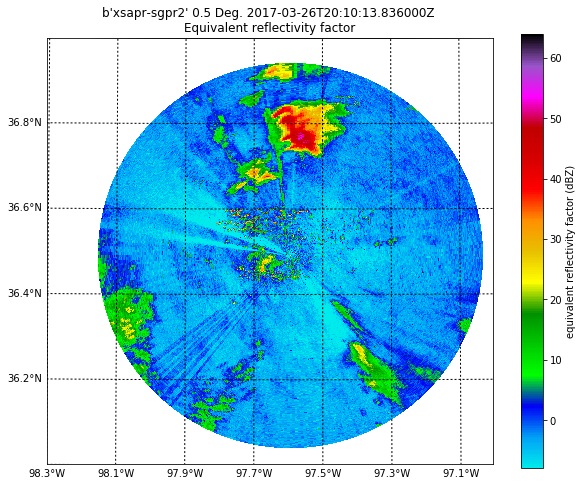

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:24:20.808666. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [24]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97

lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 0, resolution = 'c',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/windfarm_x_wide.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


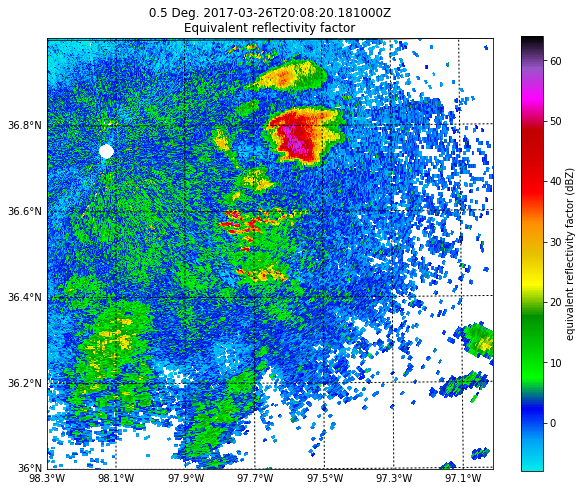

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:27:55.598059. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [26]:
time_at_start_of_radar = num2date(radar.time['data'][0], 
                                      radar.time['units'])
my_radar = get_radar_from_aws('KVNX', time_at_start_of_radar )
display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 0, resolution = 'c',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/kvnx_wide.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


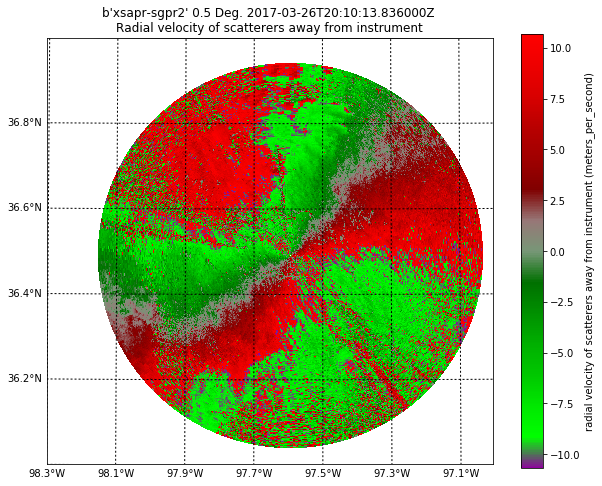

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:25.600394. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [6]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97

lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('velocity', sweep = 0, resolution = 'c',
                    vmin = -10.7, vmax = 10.7, mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)

In [7]:
my_gf = pyart.correct.GateFilter(radar)
my_gf.exclude_below('normalized_coherent_power', 0.5)

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:27.186451. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [8]:
print(radar.instrument_parameters['nyquist_velocity'])

{'data': array([ 10.69499969,  10.69499969,  10.69499969, ...,  10.69499969,
        10.69499969,  10.69499969], dtype=float32), 'units': 'meters_per_second', 'comments': 'Unambiguous velocity', 'meta_group': 'instrument_parameters', 'long_name': 'Nyquist velocity'}


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:27.238740. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


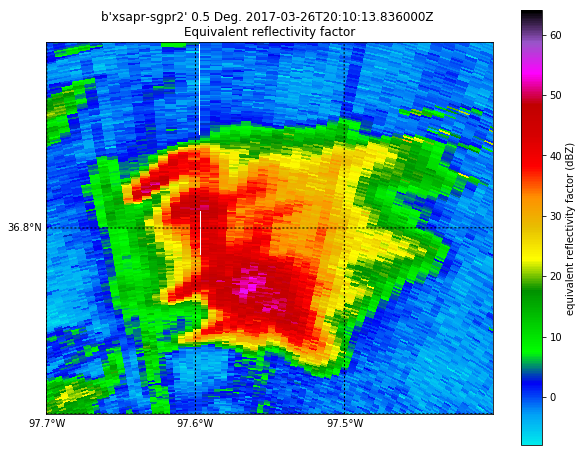

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:51:07.496714. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [28]:
max_lat = 36.9
min_lat = 36.7
min_lon = -97.7
max_lon = -97.4

lal = np.arange(min_lat, max_lat, .1)
lol = np.arange(min_lon, max_lon, .1)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 0, resolution = 'c',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/windfarm_x.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


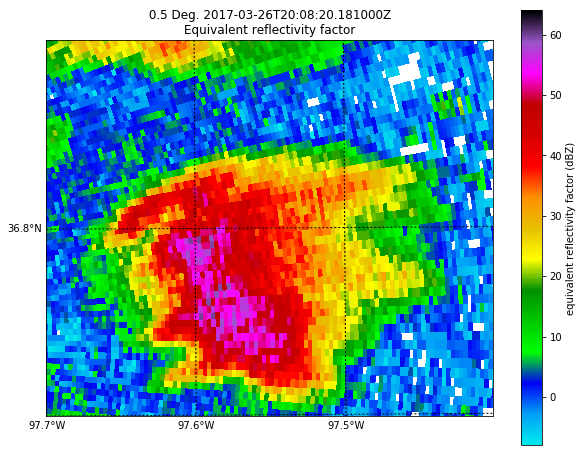

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:28.737067. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [10]:

display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 0, resolution = 'c',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/windfarm_s.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


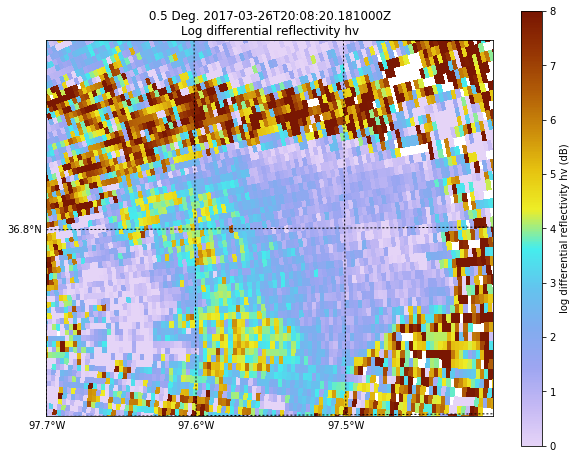

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:31.664995. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [11]:

display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('differential_reflectivity', sweep = 0, resolution = 'c',
                    vmin = 0, vmax = 8, mask_outside = False,
                    cmap = pyart.graph.cm.LangRainbow12,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/windfarm_s_zdr.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


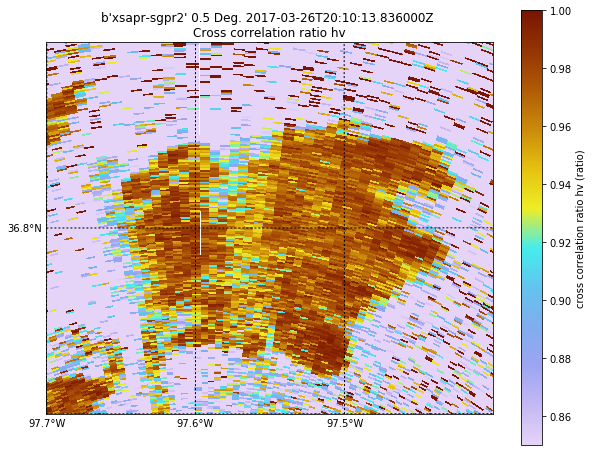

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:34.550450. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [12]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('cross_correlation_ratio', sweep = 0, resolution = 'c',
                    vmin = .85, vmax = 1, mask_outside = False,
                    cmap = pyart.graph.cm.LangRainbow12,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/windfarm_x_rhv.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


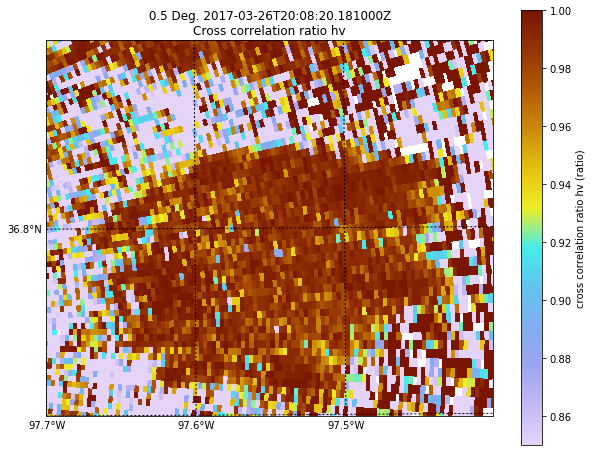

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:51:15.208946. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [29]:
display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('cross_correlation_ratio', sweep = 0, resolution = 'c',
                    vmin = .85, vmax = 1, mask_outside = False,
                    cmap = pyart.graph.cm.LangRainbow12,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/windfarm_s_rhv.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


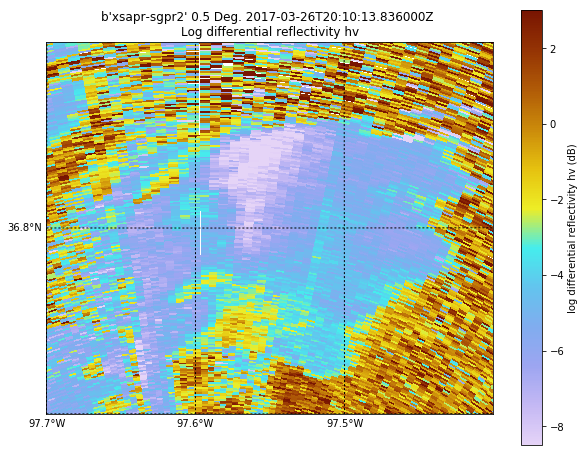

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 15:34:37.193692. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [31]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('differential_reflectivity', sweep = 0, resolution = 'c',
                    vmin = -8.5, vmax = 3, mask_outside = False,
                    cmap = pyart.graph.cm.LangRainbow12,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/windfarm_x_zdr_unc.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


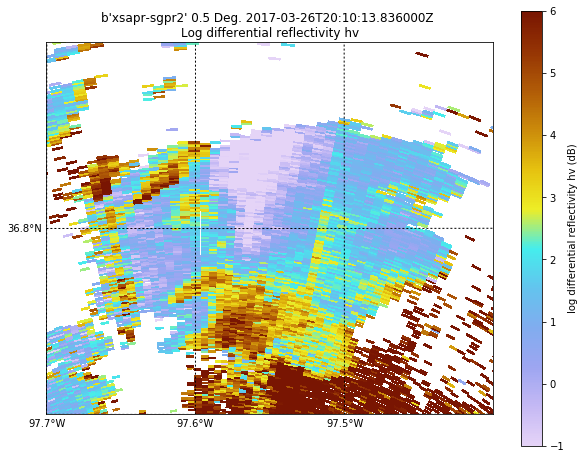

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:37.511683. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [14]:
radar.add_field_like('differential_reflectivity', 
                     'differential_reflectivity_offset',
                    copy.deepcopy(radar.fields['differential_reflectivity']['data']) + 6.7,
                    replace_existing='True')
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('differential_reflectivity_offset', sweep = 0, resolution = 'c',
                    vmin = -1, vmax = 6, mask_outside = False,
                    cmap = pyart.graph.cm.LangRainbow12,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol,
                    gatefilter = my_gf)
plt.savefig('../images/windfarm_x_zdr.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


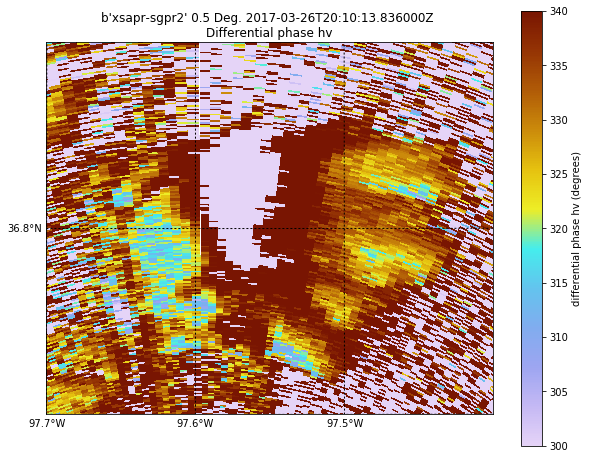

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:38.926011. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [15]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('differential_phase', sweep = 0, resolution = 'c',
                    vmin = 300, vmax = 340, mask_outside = False,
                    cmap = pyart.graph.cm.LangRainbow12,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/windfarm_x_phidp.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


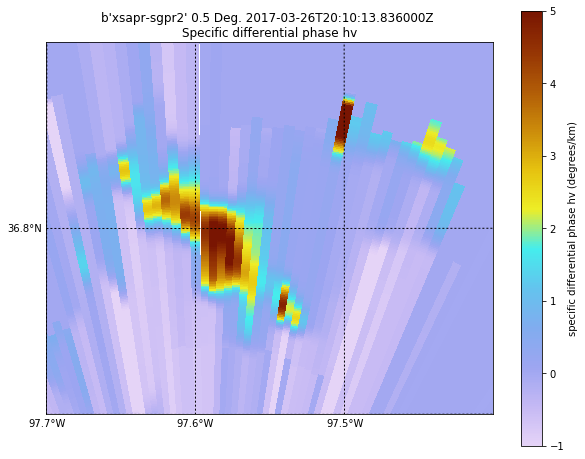

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:40.417264. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [16]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('specific_differential_phase', sweep = 0, resolution = 'c',
                    vmin = -1, vmax = 5, mask_outside = False,
                    cmap = pyart.graph.cm.LangRainbow12,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/windfarm_x_kdp.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


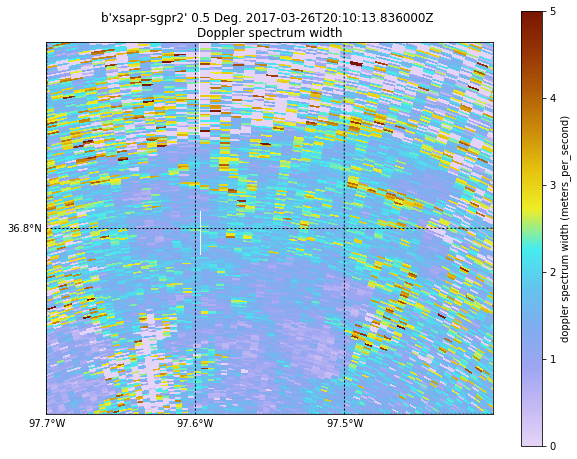

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:42.161835. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [17]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('spectrum_width', sweep = 0, resolution = 'c',
                    vmin = 0, vmax = 5, mask_outside = False,
                    cmap = pyart.graph.cm.LangRainbow12,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/windfarm_x_sw.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


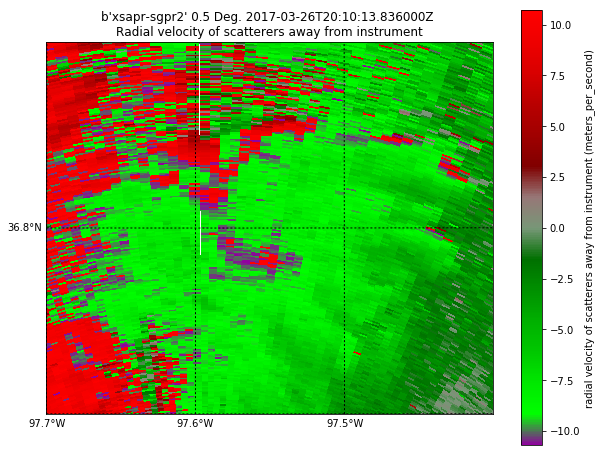

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:43.879290. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [18]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('velocity', sweep = 0, resolution = 'c',
                    vmin = -10.7, vmax = 10.7, mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)

(340, 360)

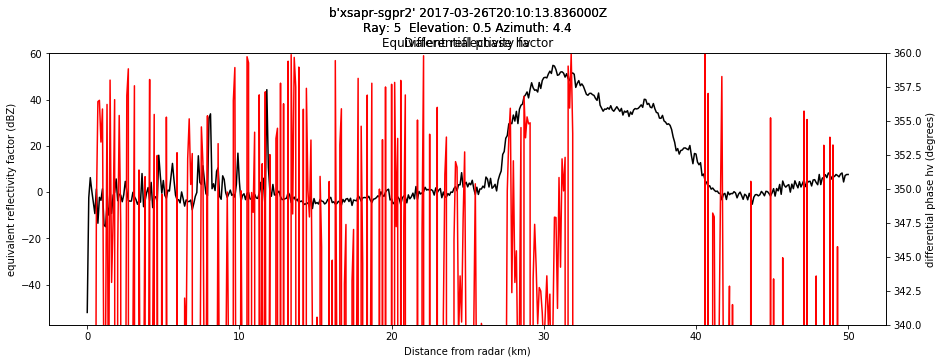

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:45.214932. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [19]:
fig = plt.figure(figsize=[15,5])
my_display = pyart.graph.RadarDisplay(radar)
my_display.plot_ray('reflectivity',5)
ax2 = plt.twinx()
my_display.plot_ray('differential_phase',5,'r-')
plt.ylim([340,360])



In [20]:
phidp_array = pyart.correct.phase_proc.get_phidp_unf(radar, 
                                                     refl_field='reflectivity',
                                                    ncpts=10, 
                                                    doc=None, sys_phase=330,
                                                    overide_sys_phase=True,
                                                    nowrap = 20)
radar.add_field_like('differential_phase', 'differential_phase_unfolded', 
                     phidp_array, replace_existing=True)


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/pyart/correct/phase_proc.py:188: RuntimeWarning: invalid value encountered in sqrt
  noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:23:45.783403. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


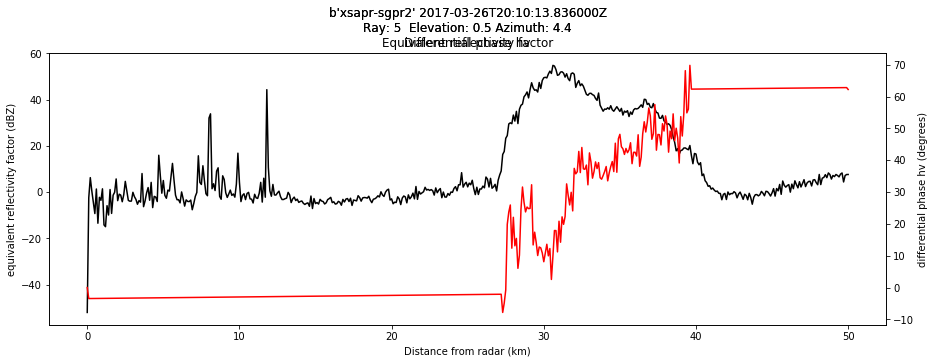

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:57:00.558118. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [30]:
fig = plt.figure(figsize=[15,5])
my_display = pyart.graph.RadarDisplay(radar)
my_display.plot_ray('reflectivity',5)
ax2 = plt.twinx()
my_display.plot_ray('differential_phase_unfolded',5,'r-')
#plt.ylim([300,360])
plt.savefig('../images/lineplot_x.png')



/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


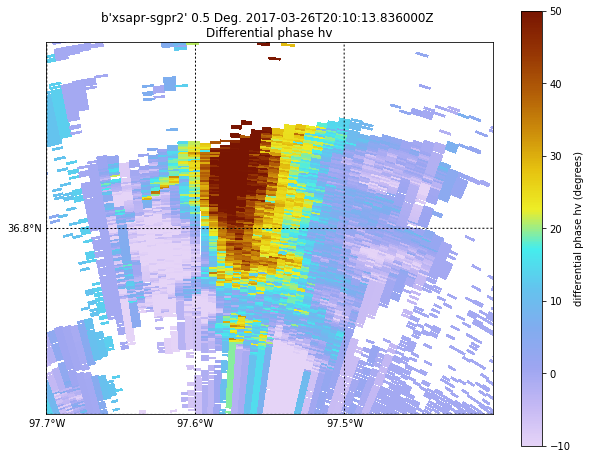

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:24:08.260330. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [22]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('differential_phase_unfolded', sweep = 0, resolution = 'c',
                    vmin = -10, vmax = 50, mask_outside = False,
                    cmap = pyart.graph.cm.LangRainbow12,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol, gatefilter=my_gf)
plt.savefig('../images/windfarm_x_phidp-u.png')

In [23]:
print(radar.fields.keys())

dict_keys(['total_power', 'differential_reflectivity', 'velocity', 'specific_differential_phase', 'cross_correlation_ratio', 'differential_phase_unfolded', 'differential_phase', 'spectrum_width', 'reflectivity', 'normalized_coherent_power', 'differential_reflectivity_offset'])


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-27 11:24:09.542859. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
